In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import f1_score

from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from os import *
from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [3]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    #plt.savefig('/home/jovyan/img1.png')
    plt.show()
    
    return conf_matx

In [4]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    #plt.show()
    
    return fig

In [5]:
def loadImages():

    image_list = []
    

    for filename in sorted(glob.glob('/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/Cropped_P276_Conc_170//*.tiff'), key=natural_keys): 
        im=cv2.imread(filename)
        #gray_image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        imarray = np.array(im)
        imarray = imarray.astype('float32')
        image_list.append(imarray)

    x_orig = np.reshape(image_list, (len(image_list), 90, 90, 3))
    
    path = '/home/jovyan/DATA_MASTER_PROJECT/leb_P276_conc_170_BINARY.csv'    
    labels = pd.read_csv(path, usecols=["Type", "Category"],
                       sep="," )
    y_orig = np.array(labels['Category'])

    return x_orig, y_orig

In [6]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=3)

In [7]:
x_orig_1, y_orig_1 = tqdm.tqdm(loadImages())
x_orig_1.shape, y_orig_1.shape

100%|██████████| 2/2 [00:00<00:00, 10305.42it/s]


((4434, 90, 90, 3), (4434,))

In [10]:
x_orig_1 = x_orig_1/255


In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_orig_1, y_orig_1, test_size=0.2, random_state=999 )
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3547, 90, 90, 3), (887, 90, 90, 3), (3547,), (887,))

In [12]:
x_train_1, x_val, y_train_1, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=999 )
x_train_1.shape, x_val.shape, y_train_1.shape, y_val.shape

((2837, 90, 90, 3), (710, 90, 90, 3), (2837,), (710,))

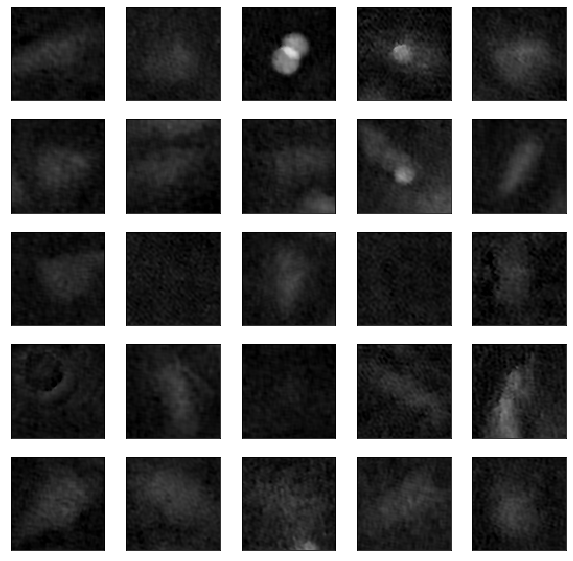

In [13]:
#Show n rabdom images to check for quality

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_1[i], cmap=plt.cm.binary)
    #plt.xlabel(class_names[y_orig_1[i]])
plt.show()

In [14]:
unique, counts = np.unique(y_train_1, return_counts=True)
dict(zip(unique, counts))

{0: 1229, 1: 1608}

In [15]:
unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))

{0: 278, 1: 432}

In [16]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 383, 1: 504}

In [17]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train_1),y_train_1)
print('weights = ' + str(weights))

weights = [1.1541904  0.88215174]


In [18]:
input_shape = (90,90,3)

In [19]:
m = Sequential()
m.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', input_shape = input_shape))
m.add(MaxPooling2D())

m.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
m.add(MaxPooling2D())

m.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
m.add(MaxPooling2D())


m.add(Flatten())

m.add(Dense(128, activation='relu'))


m.add(Dense(1,activation='sigmoid'))
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 90, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0

In [20]:
m.compile(loss= binary_crossentropy,
              optimizer = Adam(lr=1e-5),
             metrics = ['accuracy'])


In [21]:
x_train_1.shape, x_val.shape, y_train_1.shape, y_val.shape

((2837, 90, 90, 3), (710, 90, 90, 3), (2837,), (710,))

In [22]:

epochs = 100

m_h = m.fit(x_train_1, y_train_1,
            epochs=epochs, 
            callbacks = [es],
            class_weight = weights,
            validation_data=(x_val, y_val))

Train on 2837 samples, validate on 710 samples
Epoch 1/100
2837/2837 [==============================] - 3s 1ms/sample - loss: 0.6907 - accuracy: 0.5668 - val_loss: 0.6835 - val_accuracy: 0.6085
Epoch 2/100
2837/2837 [==============================] - 1s 238us/sample - loss: 0.6875 - accuracy: 0.5717 - val_loss: 0.6803 - val_accuracy: 0.6127
Epoch 3/100
2837/2837 [==============================] - 1s 220us/sample - loss: 0.6841 - accuracy: 0.5760 - val_loss: 0.6746 - val_accuracy: 0.6268
Epoch 4/100
2837/2837 [==============================] - 1s 220us/sample - loss: 0.6800 - accuracy: 0.5932 - val_loss: 0.6678 - val_accuracy: 0.6324
Epoch 5/100
2837/2837 [==============================] - 1s 229us/sample - loss: 0.6743 - accuracy: 0.5989 - val_loss: 0.6673 - val_accuracy: 0.7042
Epoch 6/100
2837/2837 [==============================] - 1s 225us/sample - loss: 0.6694 - accuracy: 0.6324 - val_loss: 0.6566 - val_accuracy: 0.6972
Epoch 7/100
2837/2837 [==============================] - 1s 2

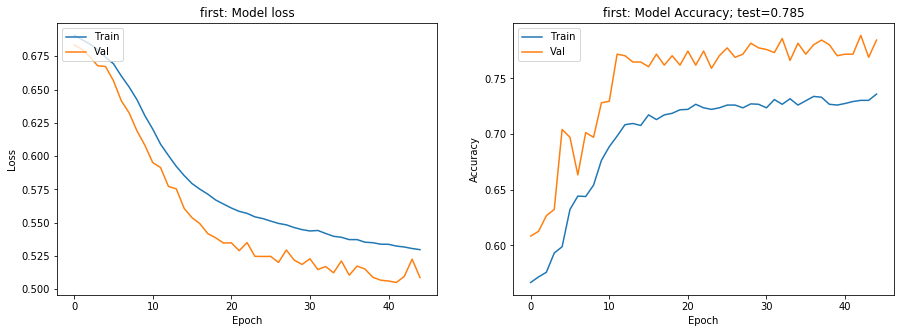

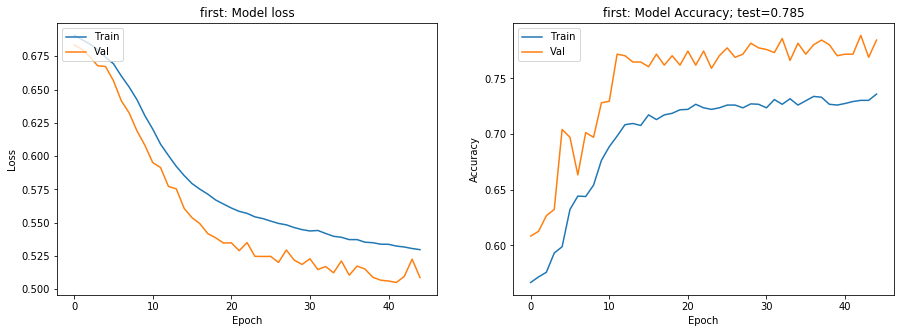

In [23]:
plot_history(m_h, 'first')

In [24]:
scores = m.evaluate(x_test, y_test)
print("\n%s: %.2f%%" % (m.metrics_names[1], scores[1]*100))

887/887 [==============================] - 0s 156us/sample - loss: 0.5250 - accuracy: 0.7418

accuracy: 74.18%


In [25]:
test_preds = m.predict(x_test)

In [26]:
t= []
for i in (test_preds):
    if i > 0.5:
        t.append(1)
    else:
        t.append(0)

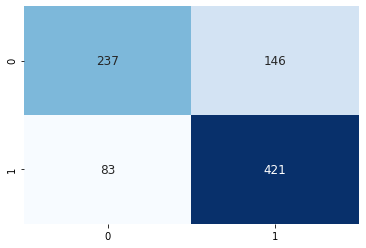

array([[237, 146],
       [ 83, 421]])

In [27]:
draw_confusion_matrix(y_test, t)

In [28]:
print(classification_report(y_test, t))

              precision    recall  f1-score   support

           0       0.74      0.62      0.67       383
           1       0.74      0.84      0.79       504

    accuracy                           0.74       887
   macro avg       0.74      0.73      0.73       887
weighted avg       0.74      0.74      0.74       887

